# A4 [57 points]

# Loveleen Kaur
# 3138819

Complete the worksheet given by this notebook and associated layers.py, fc_net.py, and solver.py files.

**Due: April 14, 2024**

# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
**[4 pts]**  Open the file `cs231n/layers.py` and implement the `affine_forward` function.


$$ f(x; W, b) = Wx+b$$

Once you are done you can test your implementaion by running the following:

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
**[6 pts]** Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

Remember that $\frac{\partial f(x; W,b)}{\partial x}$, $\frac{\partial f(x; W,b)}{\partial W}$, and, $\frac{\partial f(x; W,b)}{\partial b}$ have the same dimensions than $x$, $W$, and $b$, respectively. 

So, for example, as $x$ is diemsnions $N\times D$, $W$ is dimensions $D\times M$  and the upstream gradient (`dout`) is dimension $N\times M$, $\frac{\partial f(x; W,b)}{\partial x} = dout \cdot W^{T}$


In [5]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.7646647722652796e-11
dw error:  1.473328934429664e-10
db error:  7.72167374950876e-11


# ReLU activation: forward
**[4 pts]** Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

**Hint**: The numpy function `np.maximum(a,x)` compares each element of x with a, and returns the max value https://numpy.org/doc/stable/reference/generated/numpy.maximum.html

In [6]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
**[5 pts]** Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

$$ \frac{\partial Relu(z)}{\partial z}=\begin{cases}
			0, & \text{if $z < 0 $ }\\
            1, & \text{otherwise}
		 \end{cases} $$
         
Also remember that the gradient is the product of the upstream gradient with the local gradient!

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

**[8 pts]** We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Functions having this problem: 1, 2

Explanation:

1. Sigmoid Activation:When a neuron's output gets really close to either 1 or 0, the gradient of the sigmoid function becomes extremely small, essentially zero. This makes it hard for the neuron to learn anything new because its parameters (like weights) stop updating. This can happen if the data isn't standardized or if the weights get too big.
    - Additionally, if very large inputs are passed through the network, the gradients can become unbalanced and cause what's called an "exploding gradient."
    
2. ReLU Activation:ReLU sets negative inputs to 0. If all the inputs to a neuron are negative, the output is always 0, and the gradient with respect to those inputs also becomes 0. This means the neuron stops learning because its parameters don't change. This could occur if the learning rate is set too high, causing some inputs to suddenly push the weights to large negative values.

- In summary, both sigmoid and ReLU activations can encounter problems that hinder learning. Sigmoid can saturate and kill gradients when outputs get close to 0 or 1, while ReLU can "die" and stop learning if all inputs are negative, especially with a high learning rate

- Examples in 1D:
1. For the Sigmoid function, when it's given a significantly positive or negative input, such as 1e5, the output approaches either 0 or 1 due to its formula. Additionally, when we compute its derivative, the gradient is very close to 0, indicating minimal change.

2. Regarding the ReLU function, if it encounters any negative input, like -1, the output becomes 0 as per its formula. Consequently, the gradient also becomes 0, signifying no gradient flow during backpropagation for negative inputs.


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [8]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.960477778649495e-11
dw error:  8.162088973990222e-11
db error:  7.82672402145899e-12


# Loss layers: Softmax 
**[5 pts]** Now implement the loss for softmax in the `softmax_loss` function in `cs231n/layers.py`.
You can make sure that the implementations are correct by running the following:

In [9]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)


dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


# Two-layer network
**[15 pts]** Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

To initialize a matrix of weights, you may want to use the command: `std_scale * np.random.randn( input_dim, output_dim )`

For the forward and backpropagation steps, you can call the previously developed functions of the class `layers`:

* `affine_forward` and `affine_backward`
* `relu_forward` and `relu_backward`
* `softmax_loss`

You may also want to check the "Sandwich layer" example to get familiar with how to do the forward and backward steps. Here, you just need to extend to two layers: 
* for forward: affine W1 > relu > affine W2
* for backward: loss > dW2 > d relu > W1


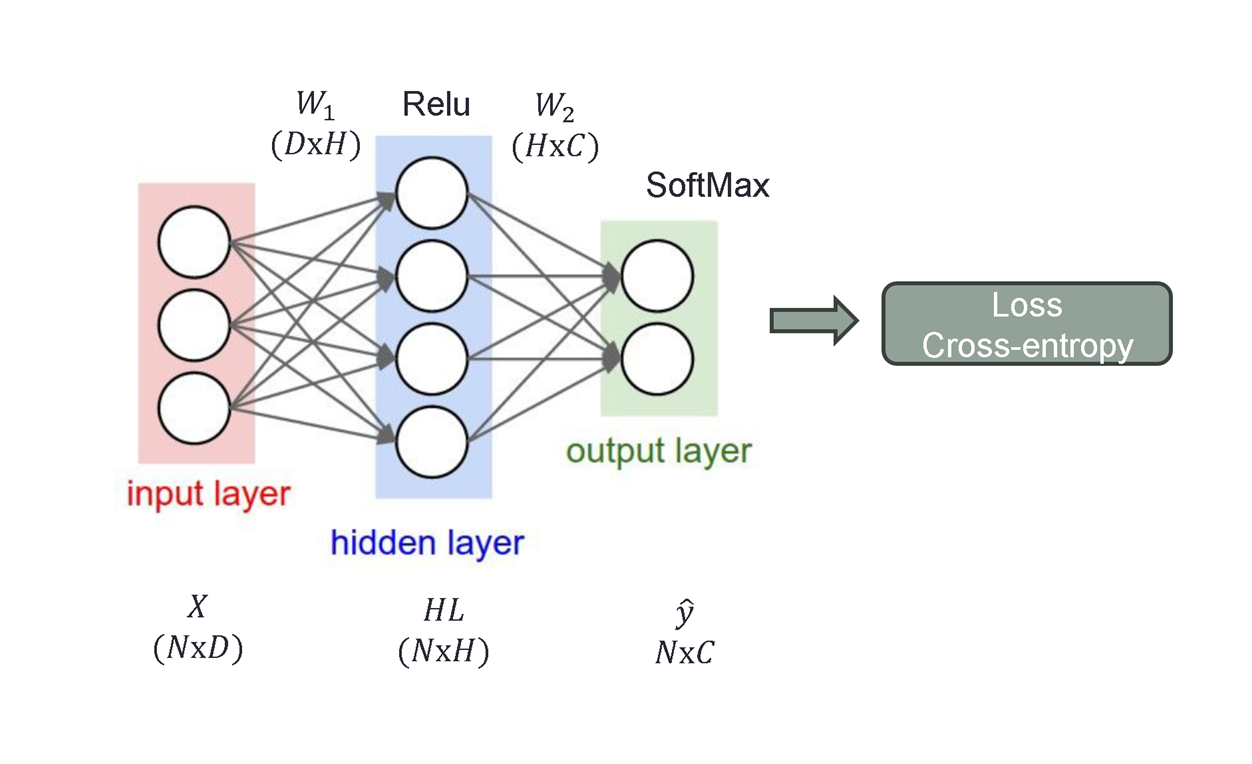

For regularization, the regularization term needs to be added to the loss function as follows:

$$ L(\hat{y}) = L(\hat{y}) + \frac{1}{2} \lambda \cdot ( ||W_2||^2 + ||W_1||^2)  $$

||W_2|| is the Frobenius norm of a matrix, which is the square root of the addition of the matrix's squared entries. So, ||W_2||^2 is $ \sum_{i} \sum_{j} w_{i,j}^2$

Also, the regulation term needs to be added to the gradient of W as:

$$\frac{\partial f(x; W,b)}{\partial W} = \frac{\partial f(x; W,b)}{\partial W} +  \lambda \cdot W $$

In [10]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
print(loss)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
26.594842695238583
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.28e-10
b1 relative error: 8.37e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
**[5 pts]** Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. You also need to implement the `sgd` function in `cs231n/optim.py`. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [11]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# define an object solver and call the function train()
solver = Solver(model, data, optim_config={'learning_rate': 1e-3})
solver.train()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.300089
(Epoch 0 / 10) train acc: 0.171000; val_acc: 0.170000
(Iteration 11 / 4900) loss: 2.258416
(Iteration 21 / 4900) loss: 2.160948
(Iteration 31 / 4900) loss: 2.016287
(Iteration 41 / 4900) loss: 2.138642
(Iteration 51 / 4900) loss: 2.059372
(Iteration 61 / 4900) loss: 1.897230
(Iteration 71 / 4900) loss: 1.801362
(Iteration 81 / 4900) loss: 1.816051
(Iteration 91 / 4900) loss: 1.767155
(Iteration 101 / 4900) loss: 1.782419
(Iteration 111 / 4900) loss: 1.861558
(Iteration 121 / 4900) loss: 1.650334
(Iteration 131 / 4900) loss: 1.698891
(Iteration 141 / 4900) loss: 1.833884
(Iteration 151 / 4900) loss: 1.763588
(Iteration 161 / 4900) loss: 1.635848
(Iteration 171 / 4900) loss: 1.962973
(Iteration 181 / 4900) loss: 1.716530
(Iteration 191 / 4900) loss: 1.652857
(Iteration 201 / 4900) loss: 1.803466
(Iteration 211 / 4900) loss: 1.646484
(Iteration 221 / 4900) loss: 1.753302
(Iteration 231 / 4900) loss: 1.665357
(Iteration 241 / 4900) loss: 1.558509
(Iterat

(Iteration 2061 / 4900) loss: 1.363604
(Iteration 2071 / 4900) loss: 1.373193
(Iteration 2081 / 4900) loss: 1.527777
(Iteration 2091 / 4900) loss: 1.294007
(Iteration 2101 / 4900) loss: 1.369872
(Iteration 2111 / 4900) loss: 1.252515
(Iteration 2121 / 4900) loss: 1.632426
(Iteration 2131 / 4900) loss: 1.221843
(Iteration 2141 / 4900) loss: 1.588294
(Iteration 2151 / 4900) loss: 1.382462
(Iteration 2161 / 4900) loss: 1.451325
(Iteration 2171 / 4900) loss: 1.232785
(Iteration 2181 / 4900) loss: 1.428744
(Iteration 2191 / 4900) loss: 1.528158
(Iteration 2201 / 4900) loss: 1.561029
(Iteration 2211 / 4900) loss: 1.545789
(Iteration 2221 / 4900) loss: 1.216724
(Iteration 2231 / 4900) loss: 1.368028
(Iteration 2241 / 4900) loss: 1.419180
(Iteration 2251 / 4900) loss: 1.338375
(Iteration 2261 / 4900) loss: 1.297813
(Iteration 2271 / 4900) loss: 1.293287
(Iteration 2281 / 4900) loss: 1.397591
(Iteration 2291 / 4900) loss: 1.448465
(Iteration 2301 / 4900) loss: 1.242521
(Iteration 2311 / 4900) l

(Iteration 4151 / 4900) loss: 1.029758
(Iteration 4161 / 4900) loss: 1.384384
(Iteration 4171 / 4900) loss: 1.469837
(Iteration 4181 / 4900) loss: 1.529209
(Iteration 4191 / 4900) loss: 1.190913
(Iteration 4201 / 4900) loss: 1.214756
(Iteration 4211 / 4900) loss: 1.133497
(Iteration 4221 / 4900) loss: 1.354617
(Iteration 4231 / 4900) loss: 1.273540
(Iteration 4241 / 4900) loss: 1.477614
(Iteration 4251 / 4900) loss: 1.584060
(Iteration 4261 / 4900) loss: 1.378007
(Iteration 4271 / 4900) loss: 1.200474
(Iteration 4281 / 4900) loss: 1.268054
(Iteration 4291 / 4900) loss: 1.154626
(Iteration 4301 / 4900) loss: 1.206561
(Iteration 4311 / 4900) loss: 1.067481
(Iteration 4321 / 4900) loss: 1.508419
(Iteration 4331 / 4900) loss: 1.348757
(Iteration 4341 / 4900) loss: 1.383121
(Iteration 4351 / 4900) loss: 1.300875
(Iteration 4361 / 4900) loss: 1.233478
(Iteration 4371 / 4900) loss: 1.221144
(Iteration 4381 / 4900) loss: 1.239890
(Iteration 4391 / 4900) loss: 1.323033
(Iteration 4401 / 4900) l

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

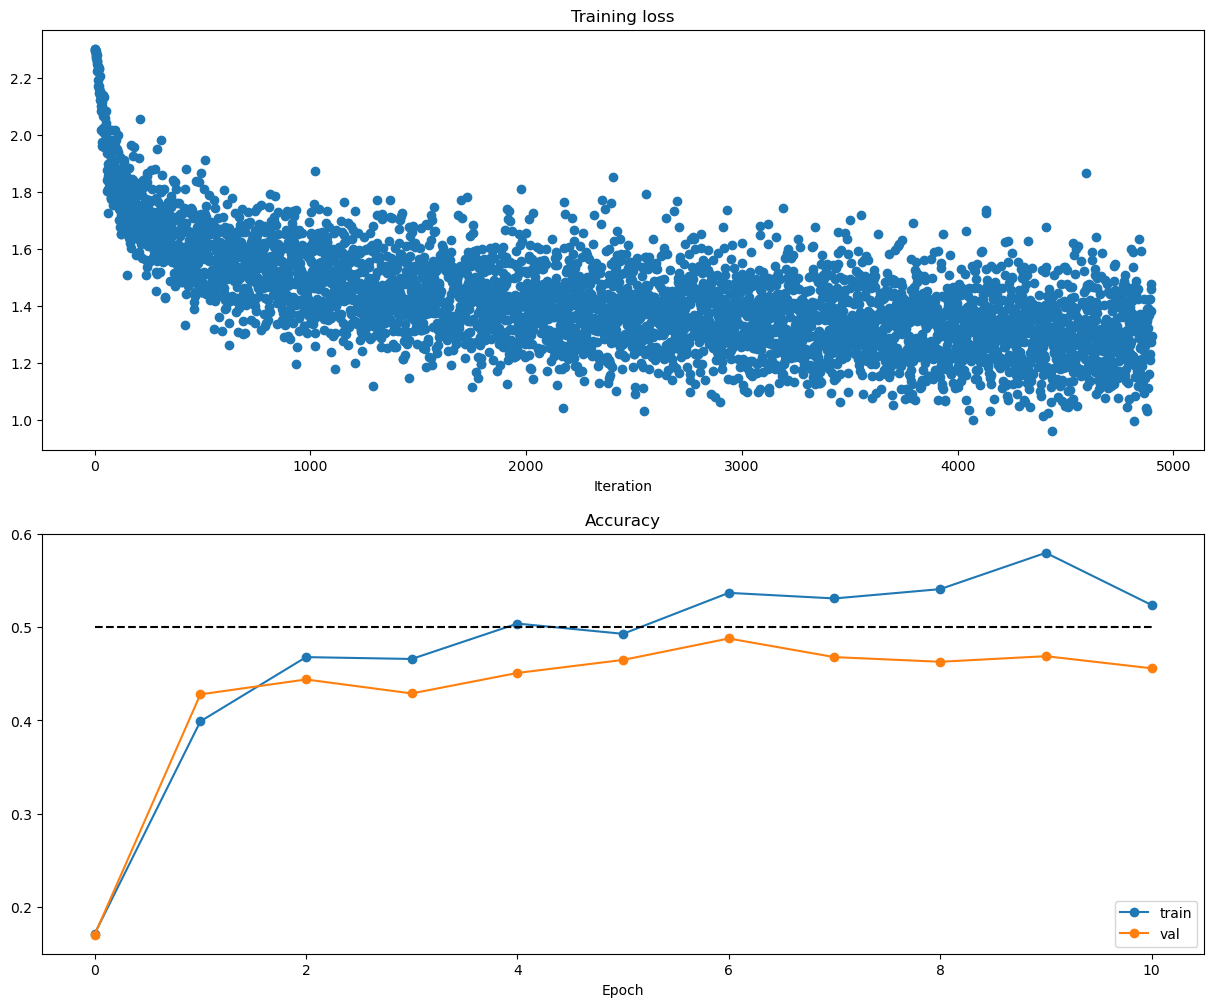

In [12]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

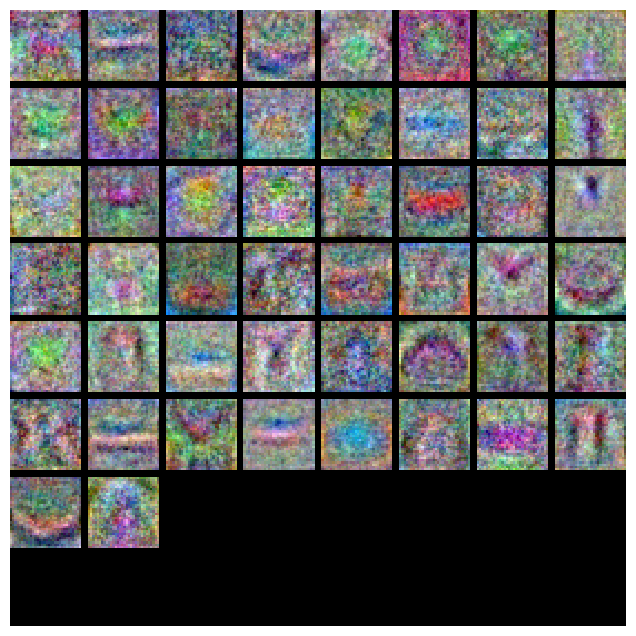

In [13]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters


**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**[8 pts]** **Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

# the block below may seem to stuck in the loop. but it manages to resolve after some time. and it is able to achieve what's required as part of this assignment.

In [14]:
import itertools
from cs231n.classifiers.fc_net import TwoLayerNet
import warnings
warnings.filterwarnings('ignore')

best_model = None

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results = {}
best_val = -1

learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Two Layer Net and train it with Solver
    model = TwoLayerNet(hidden_dim=128, reg=reg)
    solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=False)
    solver.train()
    
    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

/Users/loveleenkaur/Desktop/ACS-4953/A4/A4/cs231n/layers.py:831: RuntimeWarning: overflow encountered in exp
  expX = np.exp(x)
/Users/loveleenkaur/Desktop/ACS-4953/A4/A4/cs231n/layers.py:832: RuntimeWarning: invalid value encountered in divide
  prob = expX/ np.sum( expX, axis=1 )[:, np.newaxis]
/Users/loveleenkaur/Desktop/ACS-4953/A4/A4/cs231n/layers.py:846: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(prob[np.arange(N), y])) / N


lr 3.000000e-04 reg 1.000000e-06 val accuracy: 0.511000
lr 3.000000e-04 reg 1.000000e-05 val accuracy: 0.506000
lr 3.000000e-04 reg 1.000000e-04 val accuracy: 0.522000
lr 3.000000e-04 reg 1.000000e-03 val accuracy: 0.533000
lr 3.000000e-04 reg 1.000000e-02 val accuracy: 0.512000
lr 3.000000e-03 reg 1.000000e-06 val accuracy: 0.278000
lr 3.000000e-03 reg 1.000000e-05 val accuracy: 0.324000
lr 3.000000e-03 reg 1.000000e-04 val accuracy: 0.364000
lr 3.000000e-03 reg 1.000000e-03 val accuracy: 0.355000
lr 3.000000e-03 reg 1.000000e-02 val accuracy: 0.270000
lr 3.000000e-02 reg 1.000000e-06 val accuracy: 0.096000
lr 3.000000e-02 reg 1.000000e-05 val accuracy: 0.149000
lr 3.000000e-02 reg 1.000000e-04 val accuracy: 0.103000
lr 3.000000e-02 reg 1.000000e-03 val accuracy: 0.171000
lr 3.000000e-02 reg 1.000000e-02 val accuracy: 0.131000
best validation accuracy achieved during cross-validation: 0.533000


# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [15]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.533


In [16]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.528


## Inline Question 2: 

**[5 pts]** Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ 
Ways to decrease the gap: 1, 3

$\color{blue}{\textit Your Explanation:}$
1. TRUE - Increasing the size of the dataset can help mitigate overfitting by providing the model with more diverse examples to learn from. With a larger dataset, the model can better generalize across different variations of the input data, reducing the likelihood of overfitting. However, it's crucial that the dataset encompasses a wide range of samples to ensure that the model learns meaningful patterns rather than memorizing specific instances.

2. FALSE - Simply adding more hidden units to the model does not necessarily address overfitting. In fact, increasing the number of hidden units can exacerbate overfitting by allowing the model to learn intricate patterns and noise in the training data, which may not generalize well to unseen data. Overly complex models with excessive hidden units may memorize the training data rather than learn useful representations.

3. TRUE - Introducing regularization techniques, such as penalizing the weights with larger regularization terms, can enhance the model's robustness and mitigate overfitting. By imposing constraints on the magnitude of the weights, regularization discourages the model from relying too heavily on specific features or patterns in the training data. This encourages the model to learn more generalizable representations that perform well on both the training and test datasets.

